# Generating proteins with a conditional character-level RNN

In [0]:
import string
import glob

import torch
import torch.nn as nn
from torch.autograd import Variable

import random
import time
import math

In [2]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

if use_cuda:
  dvc = torch.cuda.current_device()
  print(torch.cuda.get_device_name(dvc))
  print(torch.cuda.get_device_capability(dvc))
  print(torch.cuda.get_device_properties(dvc))

Running GPU.
Tesla P4
(6, 1)
_CudaDeviceProperties(name='Tesla P4', major=6, minor=1, total_memory=7611MB, multi_processor_count=20)


## Prep data

In [0]:
## TODO: optimization of all_letters: instead of having the whole alphabet of small and captial letters, then get the set of letters that is present in the files

all_letters = string.ascii_uppercase
n_letters = len(all_letters) + 1 # Plus EOS marker
EOS = n_letters - 1 # get index of EOS symbol

In [4]:
all_letters

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [5]:
EOS

26

In [0]:
# read a file and split into lines
def read_lines(filename):
  lines = open(filename).read().strip().split('\n')
  lines = [line.replace(' ','') for line in lines] # remove space between the characters
  return lines

Remember to upload the files.

In [12]:
# test read of file
test = read_lines('./protein-datasets/arc_full/train.txt')
print(len(test))

1997


In [13]:
# find the categories, i.e. protein groups
all_categories = list()
path = './protein-datasets/'

for foldername in glob.glob(path + '*'):
  categ = foldername.replace(path,'').replace('_full','')
  #print(categ)
  all_categories.append(categ)

print('found protein categories: {}'.format(all_categories))

found protein categories: ['vir', 'bac', 'arc']


In [14]:
n_categories = len(all_categories)
print('Nr. of protein groups (categories) =>', n_categories)

Nr. of protein groups (categories) => 3


In [0]:
# build the category_lines dict, a list of lines per category
category_lines = dict()

for categ in all_categories:
  for file in glob.glob(path + categ + '_full/train.txt'):
    lines = read_lines(file)
    category_lines[categ] = lines

In [16]:
len(category_lines['arc'])

1997

In [20]:
for categ in all_categories:
  print(glob.glob(path + categ + '_full/train.txt'))
  print(glob.glob(path + categ + '_full/valid.txt'))
  print(glob.glob(path + categ + '_full/test.txt'))

['./protein-datasets/vir_full/train.txt']
['./protein-datasets/vir_full/valid.txt']
['./protein-datasets/vir_full/test.txt']
['./protein-datasets/bac_full/train.txt']
['./protein-datasets/bac_full/valid.txt']
['./protein-datasets/bac_full/test.txt']
['./protein-datasets/arc_full/train.txt']
['./protein-datasets/arc_full/valid.txt']
['./protein-datasets/arc_full/test.txt']


In [29]:
# average, max and min length of protein sequence overall
total_seq_len = 0
max_seq_len = 0
min_seq_len = 99999
total_seq = 0

for categ in all_categories:
  for file in glob.glob(path + categ + '_full/train.txt'):
    lines = read_lines(file)
    total_seq = total_seq + len(lines)
    for line in lines:
      total_seq_len = total_seq_len + len(line)
      if len(line) > max_seq_len:
        max_seq_len = len(line)
      elif len(line) < min_seq_len:
        min_seq_len = len(line)
  for file in glob.glob(path + categ + '_full/valid.txt'):
    lines = read_lines(file)
    total_seq = total_seq + len(lines)
    for line in lines:
      total_seq_len = total_seq_len + len(line)
      if len(line) > max_seq_len:
        max_seq_len = len(line)
      elif len(line) < min_seq_len:
        min_seq_len = len(line)
  for file in glob.glob(path + categ + '_full/test.txt'):
    lines = read_lines(file)
    total_seq = total_seq + len(lines)
    for line in lines:
      total_seq_len = total_seq_len + len(line)
      if len(line) > max_seq_len:
        max_seq_len = len(line)
      elif len(line) < min_seq_len:
        min_seq_len = len(line)

print("total seq length:", total_seq_len)
print("total number of sequences:", total_seq)
print("avg sequence lenght:", total_seq_len / total_seq)
print("max sequence length:", max_seq_len)
print("min sequence length:", min_seq_len)

total seq length: 46585269
total number of sequences: 103382
avg sequence lenght: 450.61295970284965
max sequence length: 16990
min sequence length: 7


In [36]:
# average, min and max length of protein sequence in each domain - bacteria
total_seq_len = 0
max_seq_len = 0
min_seq_len = 99999
total_seq = 0

# bac
lines = read_lines(glob.glob(path + 'bac' + '_full/train.txt')[0])
total_seq = total_seq + len(lines)
for line in lines:
  total_seq_len = total_seq_len + len(line)
  if len(line) > max_seq_len:
    max_seq_len = len(line)
  elif len(line) < min_seq_len:
    min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'bac' + '_full/valid.txt')[0])
total_seq = total_seq + len(lines)
for line in lines:
  total_seq_len = total_seq_len + len(line)
  if len(line) > max_seq_len:
    max_seq_len = len(line)
  elif len(line) < min_seq_len:
    min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'bac' + '_full/test.txt')[0])
total_seq = total_seq + len(lines)
for line in lines:
  total_seq_len = total_seq_len + len(line)
  if len(line) > max_seq_len:
    max_seq_len = len(line)
  elif len(line) < min_seq_len:
    min_seq_len = len(line)

print('-- bacteria --')
print("total seq length:", total_seq_len)
print("total number of sequences:", total_seq)
print("avg sequence lenght:", total_seq_len / total_seq)
print("max sequence length:", max_seq_len)
print("min sequence length:", min_seq_len)

-- bacteria --
total seq length: 34113615
total number of sequences: 69785
avg sequence lenght: 488.8387905710396
max sequence length: 16990
min sequence length: 7


In [37]:
# average, min and max length of protein sequence in each domain - vira
total_seq_len = 0
max_seq_len = 0
min_seq_len = 99999
total_seq = 0

# vir
lines = read_lines(glob.glob(path + 'vir' + '_full/train.txt')[0])
total_seq = total_seq + len(lines)
for line in lines:
  total_seq_len = total_seq_len + len(line)
  if len(line) > max_seq_len:
    max_seq_len = len(line)
  elif len(line) < min_seq_len:
    min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'vir' + '_full/valid.txt')[0])
total_seq = total_seq + len(lines)
for line in lines:
  total_seq_len = total_seq_len + len(line)
  if len(line) > max_seq_len:
    max_seq_len = len(line)
  elif len(line) < min_seq_len:
    min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'vir' + '_full/test.txt')[0])
total_seq = total_seq + len(lines)
for line in lines:
  total_seq_len = total_seq_len + len(line)
  if len(line) > max_seq_len:
    max_seq_len = len(line)
  elif len(line) < min_seq_len:
    min_seq_len = len(line)

print('-- vira --')
print("total seq length:", total_seq_len)
print("total number of sequences:", total_seq)
print("avg sequence lenght:", total_seq_len / total_seq)
print("max sequence length:", max_seq_len)
print("min sequence length:", min_seq_len)

-- vira --
total seq length: 11387848
total number of sequences: 30283
avg sequence lenght: 376.04755143149623
max sequence length: 7180
min sequence length: 14


In [38]:
# average, min and max length of protein sequence in each domain - archaeas
total_seq_len = 0
max_seq_len = 0
min_seq_len = 99999
total_seq = 0

# vir
lines = read_lines(glob.glob(path + 'arc' + '_full/train.txt')[0])
total_seq = total_seq + len(lines)
for line in lines:
  total_seq_len = total_seq_len + len(line)
  if len(line) > max_seq_len:
    max_seq_len = len(line)
  elif len(line) < min_seq_len:
    min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'arc' + '_full/valid.txt')[0])
total_seq = total_seq + len(lines)
for line in lines:
  total_seq_len = total_seq_len + len(line)
  if len(line) > max_seq_len:
    max_seq_len = len(line)
  elif len(line) < min_seq_len:
    min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'arc' + '_full/test.txt')[0])
total_seq = total_seq + len(lines)
for line in lines:
  total_seq_len = total_seq_len + len(line)
  if len(line) > max_seq_len:
    max_seq_len = len(line)
  elif len(line) < min_seq_len:
    min_seq_len = len(line)

print('-- archaeas --')
print("total seq length:", total_seq_len)
print("total number of sequences:", total_seq)
print("avg sequence lenght:", total_seq_len / total_seq)
print("max sequence length:", max_seq_len)
print("min sequence length:", min_seq_len)

-- archaeas --
total seq length: 1083806
total number of sequences: 3314
avg sequence lenght: 327.038624019312
max sequence length: 2951
min sequence length: 29


## Create net

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [0]:
# helper function to get random pars of (category, line)
# Get a random category and random line from that category
def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category, line

In [41]:
random_training_pair()

('vir',
 'MENRWQVMIVWQVDRMRIRTWKSLVKHHMYVSGKAKKWLYKHHYESTNPRISSEVHIPLGEASLVVTTYWGLHTGERNWHLGQGVSIEWGKKRYSTQVDPGLADQLIHLYYFDCFSESAIRHAILGHRVRPSCEYQAGHNKVGFLQYLALAALLTPKKIKPPLPSVTKLTEDRWNKPQRTKGHRGSHTMNGH')

In [0]:
# One-hot vector for category
def make_category_input(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return Variable(tensor)

# One-hot matrix of first to last letters (not including EOS) for input
def make_chars_input(chars):
    tensor = torch.zeros(len(chars), n_letters)
    for ci in range(len(chars)):
        char = chars[ci]
        tensor[ci][all_letters.find(char)] = 1
    tensor = tensor.view(-1, 1, n_letters)
    return Variable(tensor)

# LongTensor of second letter to end (EOS) for target
def make_target(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    tensor = torch.LongTensor(letter_indexes)
    return Variable(tensor)

In [43]:
# make onehot encoding of category
make_category_input(all_categories[0])

tensor([[1., 0., 0.]])

In [44]:
make_chars_input(category_lines['arc'][0]).shape

torch.Size([570, 1, 27])

In [0]:
# Make category, input, and target tensors from a random category, line pair
def random_training_set():
    category, line = random_training_pair()
    category_input = make_category_input(category)
    line_input = make_chars_input(line)
    line_target = make_target(line)
    return category_input, line_input, line_target

In [46]:
category_input, line_input, line_target = random_training_set()

print(line_target)

#for i in range(line_target.size()[0]):
  #print(line_target[i])

tensor([17, 17,  0, 21, 21, 18, 18, 18, 15, 15, 15, 18, 24,  4, 18, 21, 12,  0,
        16,  0, 19, 11,  4, 21, 15,  5, 21, 15, 15, 17, 24, 12,  0, 15, 19,  4,
         6, 17, 13, 18,  8, 17, 24, 18,  4, 11,  0, 15, 16, 24,  3, 19, 19, 17,
        21, 24, 11, 21,  3, 13, 10, 18,  0,  3,  8,  0, 18, 11, 13, 24, 16, 13,
         3,  7, 18, 13,  5, 11, 19, 19, 21, 21, 16, 13, 13,  3,  5, 19, 15,  0,
         4,  0, 18, 19, 16, 19,  8, 13,  5,  3,  4, 17, 18, 17, 22,  6,  6,  3,
        11, 10, 19,  8, 11,  7, 19, 13, 12, 15, 13, 21, 13,  4, 24, 12,  5, 19,
        18, 10,  5, 10,  0, 17, 21, 12, 21,  0, 17, 10,  7, 15, 10,  3, 21,  3,
         0, 18,  3, 11, 18, 10,  3,  8, 11,  4, 24,  3, 22,  5,  4,  5, 19, 11,
        15,  4,  6, 13,  5, 18,  4, 19, 12, 19,  8,  3, 11, 12, 13, 13,  0,  8,
        11,  4, 13, 24, 11, 16, 21,  6, 17, 16, 13,  6, 21, 11,  4, 18,  3,  8,
         6, 21, 10,  5,  3, 18, 17, 13,  5, 10, 11,  6, 22,  3, 15, 21, 19, 10,
        11, 21, 12, 15,  6, 21, 24, 19, 

## Training the net

In [0]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
      if use_cuda:
        output, hidden = rnn(category_tensor.cuda(), input_line_tensor[i].cuda(), hidden.cuda())
        #loss += criterion(output, target_line_tensor[i])
        loss += criterion(output, torch.LongTensor([target_line_tensor[i]]).cuda())
      else:
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, torch.LongTensor([target_line_tensor[i]]))

    loss.backward()
    optimizer.step()
    
    #return output, loss.data[0] / input_line_tensor.size()[0]
    return output, loss.data.item() / input_line_tensor.size()[0]

In [0]:
# to keep track of how long training takes
def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
n_epochs = 1000
print_every = 50
plot_every = 50
all_losses = list()
all_epochs = list()
loss_avg = 0 # Zero every plot_every epochs to keep a running average
learning_rate = 0.0005

#rnn = RNN(n_letters, 128, n_letters)
rnn = RNN(n_letters, 512, n_letters)
if use_cuda:
  rnn.cuda()
  print('Using GPU %s with compute capability %s' % (torch.cuda.get_device_name(dvc),torch.cuda.get_device_capability(dvc)))
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()

for epoch in range(1, n_epochs + 1):
    output, loss = train(*random_training_set())
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        all_epochs.append(epoch)
        loss_avg = 0

Using GPU Tesla K80 with compute capability (3, 7)
0m 19s (50 5%) 3.1717
0m 36s (100 10%) 2.9321
0m 50s (150 15%) 2.9300
1m 7s (200 20%) 2.9316
1m 24s (250 25%) 2.9471
1m 38s (300 30%) 2.9755
1m 53s (350 35%) 2.9152
2m 7s (400 40%) 2.9209
2m 24s (450 45%) 2.8163
2m 39s (500 50%) 2.9052
2m 55s (550 55%) 2.9412
3m 15s (600 60%) 2.8682
3m 34s (650 65%) 2.8594
3m 49s (700 70%) 2.9405
4m 2s (750 75%) 2.8676
4m 17s (800 80%) 2.8739
4m 32s (850 85%) 2.9408
4m 46s (900 90%) 2.8544
5m 1s (950 95%) 2.9420
5m 19s (1000 100%) 2.9489


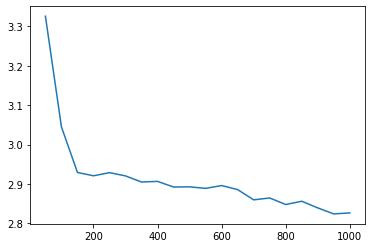

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_epochs,all_losses)
plt.show()

## Samling the network

In [0]:
max_length = 6000

# Generate given a category and starting letter
def generate_one(category, start_char='A', temperature=0.5):
    category_input = make_category_input(category)
    chars_input = make_chars_input(start_char)
    rnn.cpu() # move back to cpu
    hidden = rnn.init_hidden()

    output_str = start_char

    for i in range(max_length):
      if False: #use_cuda:
        output, hidden = rnn(category_input.cuda(), chars_input[0].cuda(), hidden.cuda())
      else:
        output, hidden = rnn(category_input, chars_input[0], hidden)
        
        # Sample as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Stop at EOS, or add to output_str
        if top_i == EOS:
            break
        else:    
            char = all_letters[top_i]
            output_str += char
            chars_input = make_chars_input(char)

    return output_str

# Get multiple samples from one category and multiple starting letters
def generate(category, start_chars='ABC'):
    for start_char in start_chars:
        print(generate_one(category, start_char))

In [0]:
#res = generate('arc', 'A')
#print(len(res))
#print(res)

In [0]:
res = generate_one('arc', 'M')
print(len(res))
print(res)

3016
MNILHFGLIKTGVGDIGVTVVLPAPNPFVVDITINNYGDNALFLEIPIVYESVNEVLKERENFILRVVKLYKEFEEAAKEILVIVSDGYYFDVDVALGAAVGKISKEDEIIVKAIGDLVIITSLMTVIFEMESILDCKEVEVLVKDAVGLGRATAEEKGGGVVIKLTREVLLSDGRGPDLRRKAVIIGKSEYAIPVIYKDVYAVEWSVKDESAYLLGIEDIIDNTSLRKLGDLGAEGKPLVVKEYDLAAVELEDKALGRELKIAKPEALEYAIAALKGLETQESVSFAVPPKDVVSELAEKFKTRAKEGLTARGLLLKGATGSAVEFESKGKRAARTFDSDVLEGIGELKTKLVIIGVVEGAVGAAAIRVELDIIKRIVLSIVRTVKDSVLETLAQLSGVELYALVKGAIKVRVGMIKPTIYNEKTFDVLGLNTIASDRVAVVLALPEDGRELGIPGLKKLRSEELDARTDRVNRVRYEIVRAIELIEGVGVEERLIENILILEQAFVPKDIRIAAKAHLRAVSHVEELRRISLIKPIGTGAPYAVLGLENAVPAPILAVKDLIVEIKVAIVEEEEERKLGTAIILEGMEYKGTFLVRKLDAEGDYREGGNKIEKNVGVDEEKMGYQADLGKFRLEEPKAVPKAYVGIDGKGSSAGVLGRRLTVLASDLVDLLGVSGVVHPIEGKIKELEADAEKRENYLKTFLNRKEGKIKRKELYKAATVSVLLNEAEERSKPLEEVEVITKVFSVVAGLDVHIFIPVIIGEGSEDKLSIIALSTVDGKARKKFTDLEKARKLRVSVIKEMDDREVTDFDFGIKLIPIPYGAQYAGEPGGFSRIIPEDEPGDFGETIKRGVERLHETELDIEGVPGKYEEISQAAVEKGGFGVLIRDLILKIVNYALNNFVGEKLYKHTMVRGRNRGENIKVKLGLAQTEEALVEFKVERRAGRIESEDSKEAIPVVLVRNPYTDIKVITGRVVTDGAALTGGDAADGIAEGL

In [0]:
res in category_lines['arc']

False

In [0]:
res = generate_one('arc', 'MAADIFAKFKKS')
print(len(res))
print(res)

1529
MAADIFAKFKKSEGVGATYLGFVSSPEVIPGLPDILTEVGLLVELEVEVAALCLLLAAIKIGVIILNYRLEKGMRVAIEDVDVWNVLVEDILGGNGVCVPEKAIENILSYLLILGVLAEVVEVSEEGNKVGEFLVNIGAAVIGVIVILEGEGEKLVEEHGRNEKLGLDFSIYLEEGIKALEVVVEEGLGVLARRQEARRKVGKPVAELLGHGYEGRFKEVLVDPEVVSAILDLVIILKHYGELDEDLDIEVEVTQVGLGLWGYLTGGFFDWLKLTGKAALKLAAILGGIELKKEKFVSVLPKGIRILKRLDYDEGIVDSLNYFDKLAEEILEEEEKKKGKKKAIIEVAIELAEKAKKVELEGRKRILLIKGFMYTTPGEFEDVLVSIALGEGHLYVGECFLIPDEDYEELIKPYYNLSDSHIAVGVLKVVLLTELAGGLGFKVSIPKIISGLEGLVAVISEKVEEEELGEFAILSEIIGLEALKYFDKIEGNKVKLIEVRLRKEDKYVIVSDVDIKEVGEGQVLAFLVGYVIIARENIPKKKKEIKDYEIKLGLFDSLIYKKKIGEFFEEELIELEDNVLKDQEIEELVDLGADVGIVGLVRVLVGGYSNKPIKPVDDKEEVLKNKKILKLEEALGLIVSYVDIPEFASQVINKKIADENLSSSKEVAIRGIIVGMRVGHPVSGVLEAVEEDEVGIEGRIIGGALLERLSTVLGHLIYGALFGLSAISAIVARIEEEKIVFPLIPNVCEILSEINKEEAEVGILDPVVYKTGSDAAITTAVREGGEAVEVVPKTQKIIVDWGAELYWSFDRELIRVRFRLRLTILENMVKVAQEEIRKAIVKIVGDRLDDILTEGGGWGVKRASILTHPRISLPLTARGAIAIVHAALGEDAILSVKYRKIVYENIVGREVSLELGEDAAVFLGKMGETVLVGVGLALAEAAAAAAVGDFQKLRPMTFIGLAKLAEGLDLLVEQVIELLETAGELGLKPSEIRRE

In [0]:
res = generate_one('arc', 'gshmkmgvke'.upper())
print(len(res))
print(res)

416
GSHMKMGVKEESAMAPAAMLDVVLLAVPIKSRERLGSAVRSIEGLLREAIILKSATIKGIKAIEKRLEDDRSKVDADVGATDEIAFRAIAVLAEVVREVERSRIEELKHVGGVESPLTKEFRSPIDVLEEVKEGILTAALKADKYALSNNIDIYELGVEIIGINKSREHGQKDAGKAGSIRESVELSAGEAIEIKGDKRLSVVAKRQKLTEIRKGLEITGEKSAEERLGRLLFAVDIRDVVPGKIQIHKFEPLGGVVVELMVIMGVAPLDLTHTLIDVRGEALGLREKELYIAGDSNDKVTEFIIEVEGEITARLMVRAKALLRFRPVRRYTVPELAKRRDLQKPLGVVGKFKVMVTKETGRIVELEIPLTKSSVGRIVGGVIKNVGDAGSADGGMDVLEAILRGYIRYNGVAPLG


In [0]:
res = generate_one('arc', 'M'.upper())
print(len(res))
print(res)

1406
MSILKAREALLVNAKIKDIVDPDARKVKPLPAPLIEPKDSISLVAIEPLAKKGELLDLGDSIILISLILGVYKEEDALKKLFSLAAFGLRVYPAASKEDFGKKSELRHPEIGSAVNVEIEVGMAGYALAEKVAFLGAAMDDEDVEGDNMINIEKIVSFEIEKIVDKTAFYQGDLSLEDRALDLGVADEVISQVATLLVAKTKLVGEESLLTVIEVIVGIVGIARLLELKKIRPFLGLRLFERGSEDLTIEHDMEDRFVDALVSADSLGLAEVTLKEGVFIRTRLDEYISEVVSLEMLGLFDLLLDMILSRISSYSAISVNEELKRGPLAGLLGSADVAIGLGARDYIRRRIGGKPIGLYSVELRPAVPNYTYGAIGGQLTENYKIVGVLPGNAGQKVGEEPIKTISPEIALQYLSVPENALTNVLAVLEIEQGGEDLTKVETIIRIKVVIIPNKPKLALIVDVDGADEDLPPVGKVDETPLLIALIETLVSGAVSIALGTTRKAIRGQVQGLKEEAHLAIGLRAEIIPTLISLNKRVEEDGGNQLARLAVSIVVVVGPAEVIETIVSGPEVDLEAQVDHGRDRLGLEFIGDVTVGEVSTESILKIAEEESAEAQLLGEMIRFPDIGGLITMAGSNTWAGLAPLGVRIVTIDVVETAFRAIVAFIVNADRMDKFTIALGTGLNLMSAAYHLYSRLNYVDLAEGPRKVKYLPLLKTVKAIKLGKLGFDEELVADEGRWILTGSSAVEIGIAVAPILKVGVADGEYRGSENGKVLSQLVLAGALIVSKLIDSAIGIKISEIVDYEKDKLVKGLMKPPMLVRGPEARSELVVPRGISLKKLKFLDRLNLESKLKLIYRDVVVLALERNEWLVDSNIGRLVGLIVAYKYKIRVVGSNAIMALVLEMDTEAILKLAKVLKIVTYLTEWELGKQIKDKPIVLPDLIVKAGEEVDLIYLSIVEEGDSGVEILLQRDSVYGIGELGKVRDLSPIVKPYYLAAQK

In [0]:
res = generate_one('vir', 'M'.upper())
print(len(res))
print(res)

883
MGHPMEGPALSLSGDLAVLPDLLIAVSVGPEVGIDGILLKQKLAGQTKGLKFVYDPGGQSTPKAVKIVDSLRMALVLVGQLNGDGLVVDTVRVKHATVGTRLGLDYGDGHRPAIHLCIRLLPRAEKPVGLHEWQVDLTEAGLLERQKNGGLISSHPEVTRNVQRRGWQPRRKQVGPLQNKGIEGNWRWMRRLTVEILQLVVTASHTGKGHIRVTPSVTLPRASLGPDAITLLRTRVGKAILRHMREMPKNGSEIPQLLVTLPYIPPGLGQLRGGTETQPNTWKLQGALSRPLSIGNRRNTTFAIGSSIGHMYSTVPGTGHLVVRHLSYITALPGIVKTKEVVSDNVVDSLPYLQRLKAPSKDSLIALLVMPGSALRLRPPLTLDTAQAPVARIQSSACYLGHTRLGKNPISLLGLPHMMSNSTSSAKIGPGSPLARPPIVQGYLTLPLATGHYWGTLNRYYSLWNVQKVPILRVIGTLGLIKSLYKTETGVHHGAGVTYNDTSKGALPRHQKVRNVIGTNNTAIQRALERDPSARGKNILLYARNTLDDLIRALGTLAPEIVDARERVLPQTFSTRAVATKNEGVTISAREIDTTELEYPLETHLKVFKEIPRAIILMEEIPTTVFSRIISIHTTPDVLAGLLGTLISKPLLQVDFSVDAETVGGHQVSPGPYDRVQVPRLQALTGELPTLPEADLNLEELAALTGLAASGLIPGKGKRATRAIPGHIVLIHQSSGEGNLRAWQVPNDSAFPTLPYKVGWLVEHKYPLSFLSSLTKRNITILILLYYPGLYRVNNTFATAADQVRIPREDLPSGTEENSDVTTPSKIPKTGEAEYSGDKGHNLINHIMSSLNGGPSAGILIVTGLVDKYVGTQVEAKQYRLRH


In [0]:
res in category_lines['arc']

False